In [1]:
# !pip install ccxt scikit-learn pandas numpy matplotlib seaborn mplfinance ipywidgets # tensorflow

In [2]:
import ccxt
import talib
import numpy as np
import pandas as pd
import mplfinance as mpf
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
import mplfinance as mpf
from IPython.display import display


In [3]:
exchange = ccxt.binance({'enableRateLimit': True,})
symbol = 'XRP/USDT:USDT'
timeframe = '1m'
limit = 350

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.tail())

                       open    high     low   close     volume
timestamp                                                     
2025-10-24 20:55:00  2.5084  2.5096  2.5082  2.5092    73368.8
2025-10-24 20:56:00  2.5093  2.5115  2.5092  2.5105   253525.8
2025-10-24 20:57:00  2.5104  2.5147  2.5086  2.5116  1228488.5
2025-10-24 20:58:00  2.5117  2.5136  2.5109  2.5116   346104.0
2025-10-24 20:59:00  2.5117  2.5131  2.5110  2.5130   446789.7


In [4]:
df['MAX']      = talib.MAX(df['close'], timeperiod=14)
df['MIN']      = talib.MIN(df['close'], timeperiod=14)
df['RSI']      = talib.RSI(df['close'], timeperiod=14)
df['DX']       = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADX']      = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADXR']     = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=14)
df['TRANGE']   = talib.TRANGE(df['high'], df['low'], df['close'])
df['ATR']      = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['MFI']      = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['PLUS_DI']  = talib.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['OBV']      = talib.OBV(df['close'], df['volume'])
df['STDDEV']   = talib.STDDEV(df['close'], timeperiod=14, nbdev=1)

df.dropna(inplace=True)

print(df.tail())

                       open    high     low   close     volume     MAX  \
timestamp                                                                
2025-10-24 20:55:00  2.5084  2.5096  2.5082  2.5092    73368.8  2.5093   
2025-10-24 20:56:00  2.5093  2.5115  2.5092  2.5105   253525.8  2.5105   
2025-10-24 20:57:00  2.5104  2.5147  2.5086  2.5116  1228488.5  2.5116   
2025-10-24 20:58:00  2.5117  2.5136  2.5109  2.5116   346104.0  2.5116   
2025-10-24 20:59:00  2.5117  2.5131  2.5110  2.5130   446789.7  2.5130   

                        MIN        RSI         DX        ADX       ADXR  \
timestamp                                                                 
2025-10-24 20:55:00  2.5020  58.670490  12.155663  15.448531  15.264591   
2025-10-24 20:56:00  2.5026  61.637216  22.272199  15.935936  15.085603   
2025-10-24 20:57:00  2.5043  63.992505  35.702690  17.347847  15.845153   
2025-10-24 20:58:00  2.5059  63.992505  35.702690  18.658907  16.569548   
2025-10-24 20:59:00  2.5059  66

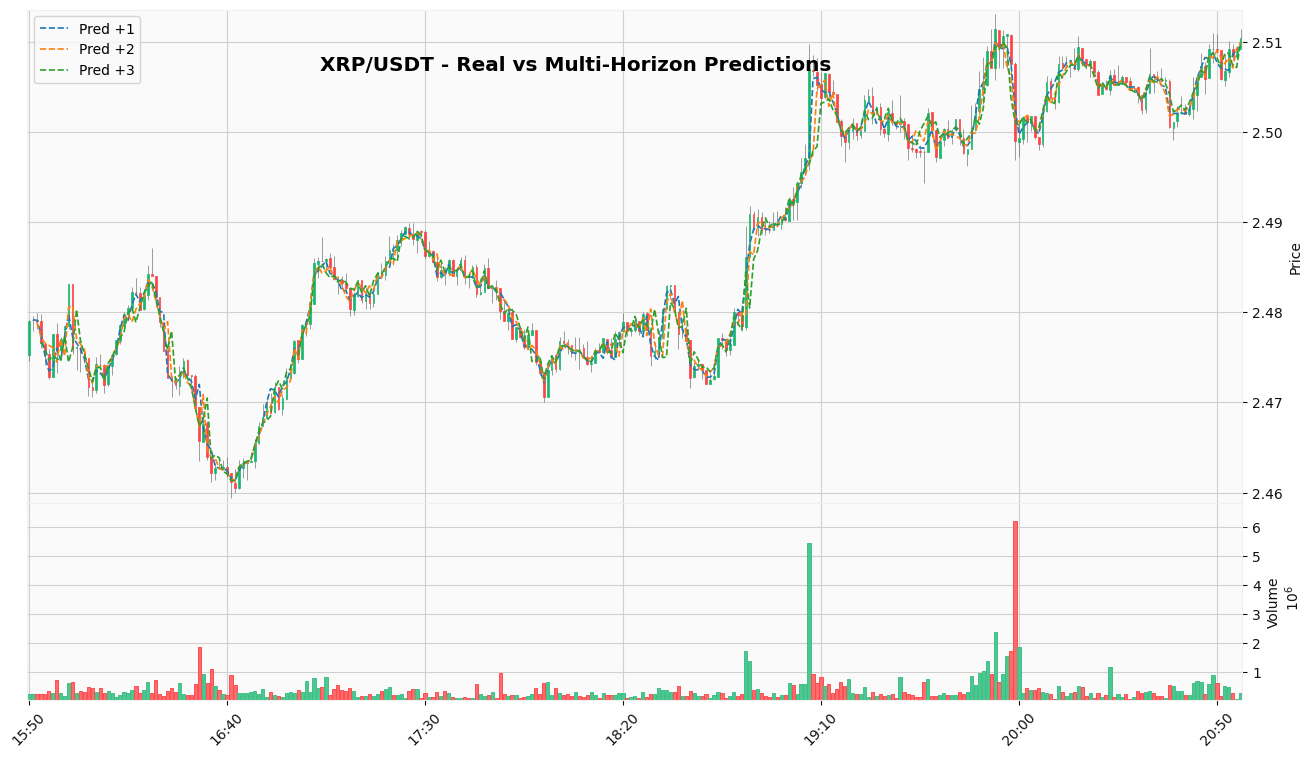

In [5]:
future_candles = range(1, 4)

for i in future_candles:
    df[f'close_future_{i}'] = df['close'].shift(-i)

df.dropna(inplace=True)

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'MAX', 'MIN', 'RSI', 'DX', 'ADX', 'ADXR',
    'TRANGE', 'ATR', 'MFI', 'MINUS_DI', 'PLUS_DI',
    'OBV', 'STDDEV'
]
features = df[feature_cols]
targets = df[[f'close_future_{i}' for i in future_candles]]

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred_all = model.predict(features)

pred_cols = [f'pred_close_future_{i}' for i in future_candles]
df_pred_all = pd.DataFrame(pred_all, columns=pred_cols, index=df.index)

df_full = pd.concat([df, df_pred_all], axis=1)

addplots = []
for i in future_candles:
    src_col = f'pred_close_future_{i}'
    plot_col = f'{src_col}_at_t_plus_{i}'
    df_full[plot_col] = df_full[src_col].shift(i)
    addplots.append(
        mpf.make_addplot(
            df_full[plot_col],
            type='line',
            width=1.2,
            linestyle='--',
            panel=0,
            secondary_y=False,
            label=f'Pred +{i}'
        )
    )

mpf.plot(
    df_full,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=addplots,
    title='XRP/USDT - Real vs Multi-Horizon Predictions',
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(14, 8),
    tight_layout=True,
)
